In [217]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from category_encoders import TargetEncoder


### Introduction
Dans ce notebook, nous explorons des données immobilières avec pour objectif de prédire les prix de vente à partir de leurs caractéristiques. 
Nous utilisons des outils de visualisation pour mieux comprendre les relations entre les variables, suivis de la construction et l'optimisation d'un modèle prédictif.


In [218]:
# Chargement des fichiers
train_data = pd.read_csv("train.csv")  
test_data = pd.read_csv("test.csv")    

# Aperçu des données
print("Structure de train_data :")
print(train_data.info())
print("\nStructure de test_data :")
print(test_data.info())


Structure de train_data :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nu

## Visualisation des distributions des variables
## Graphique 1 : Distribution de la variable cible SalePrice

Objectif : 
- Visualiser la répartition des prix de vente dans les données d'entraînement pour détecter une éventuelle asymétrie ou des valeurs aberrantes qui pourraient influencer le modèle.

/Users/noakassabi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


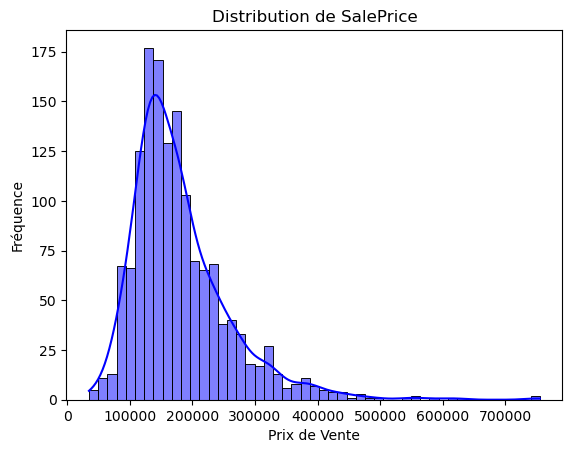

In [219]:
sns.histplot(train_data['SalePrice'], kde=True, color='blue')
plt.title("Distribution de SalePrice")
plt.xlabel("Prix de Vente")
plt.ylabel("Fréquence")
plt.show()


## Graphique 2 : Heatmap des corrélations

Objectif : 
- Identifier les relations entre les variables numériques, notamment celles qui ont une forte corrélation avec SalePrice. Cela aide à sélectionner les variables les plus pertinentes pour le modèle.

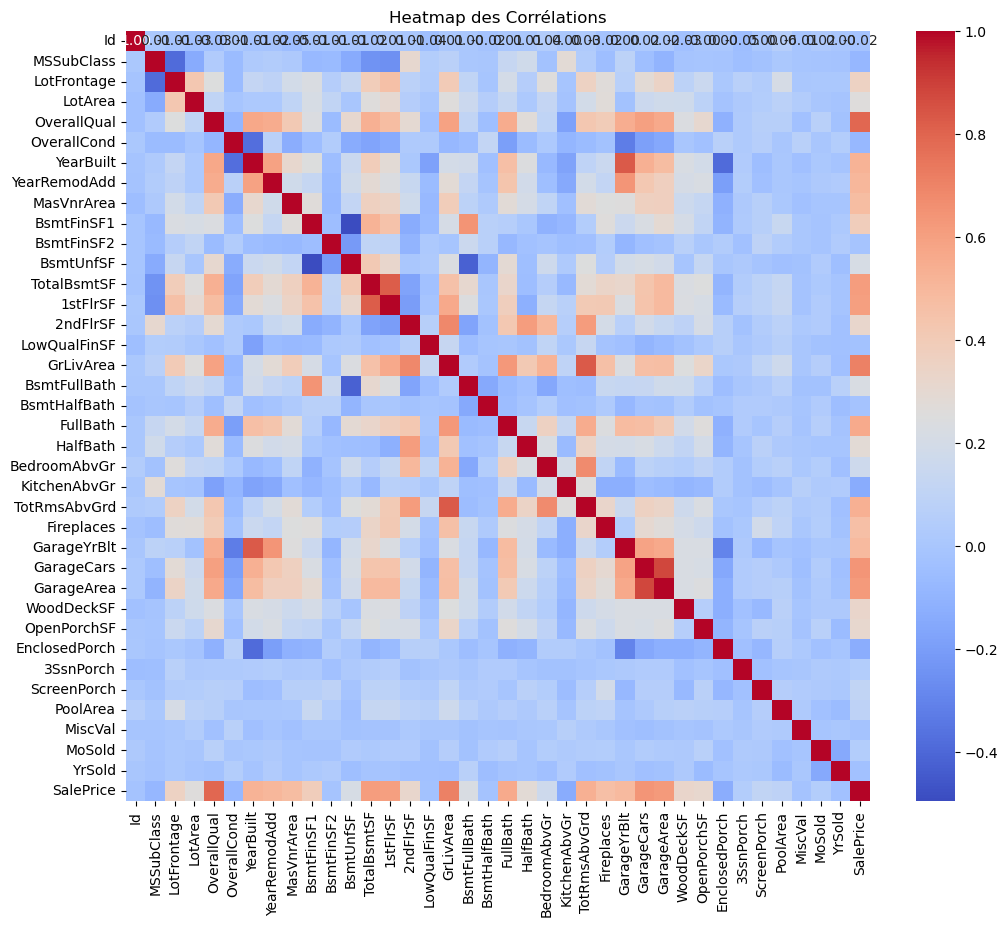

In [220]:
# On sélectionne uniquement les colonnes numériques
# On utilise la méthode select_dtypes pour filtrer les colonnes du DataFrame train_data
# qui ont des types de données numériques (int64 ou float64). Cela exclut les colonnes catégoriques ou autres types.
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# On calcule la matrice de corrélation sur les colonnes numériques uniquement
# La methode .corr() calcule les coefficients de corrélation entre les colonnes sélectionnées.
correlation_matrix = train_data[numerical_cols].corr()

# Heatmap des corrélations
plt.figure(figsize=(12, 10)) #taille de la figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
# - annot=True : affiche les valeurs numériques dans chaque cellule.
# - fmt=".2f" : limite l'affichage des valeurs à deux décimales.
# - cmap="coolwarm" : définit la palette de couleurs utilisée pour la heatmap.
plt.title("Heatmap des Corrélations")
plt.show()





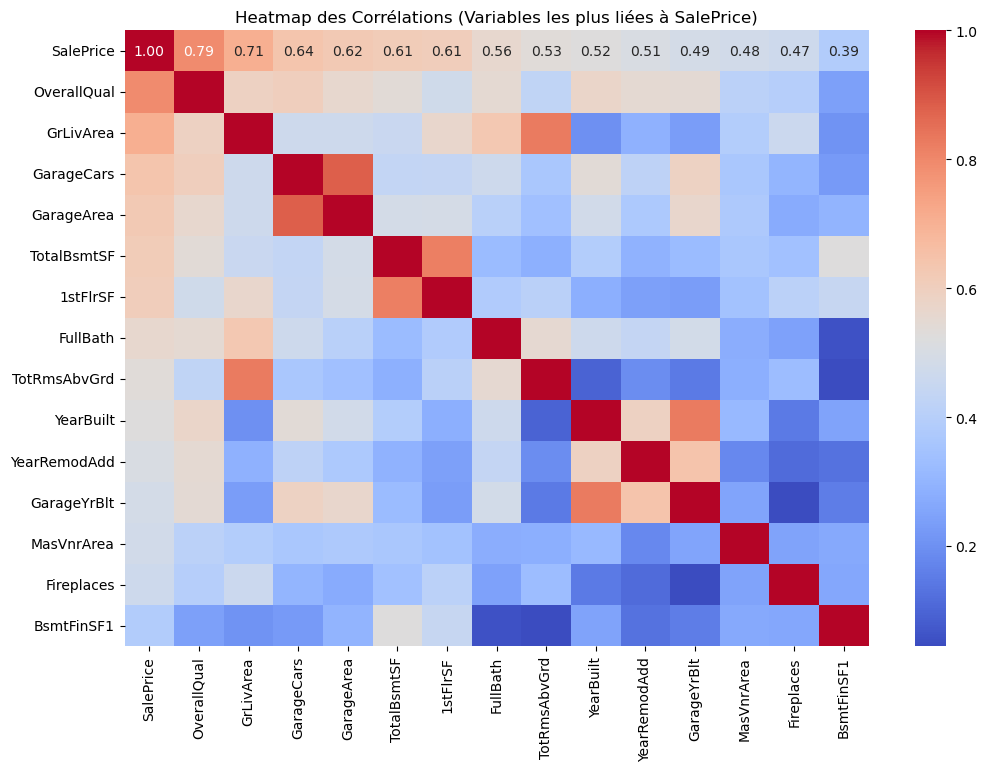

In [221]:
# On sélectionne uniquement les colonnes numériques pour la matrice de corrélation
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# On calcul de la matrice de corrélation sur les colonnes numériques uniquement
correlation_matrix = train_data[numerical_cols].corr()

# On filtre les variables ayant une forte corrélation avec SalePrice
# On prend la colonne 'SalePrice' de la matrice de corrélation et calcule les valeurs absolues des coefficients.
# Les variables sont triées par ordre décroissant de corrélation absolue avec 'SalePrice'.
# On sélectionne les 15 variables les plus fortement corrélées avec 'SalePrice'.
high_corr_features = correlation_matrix['SalePrice'].abs().sort_values(ascending=False).head(15).index

# La méthode .loc permet d'extraire une sous-matrice basée sur les variables identifiées (high_corr_features).
# Cela permet de se concentrer uniquement sur les relations entre les variables les plus pertinentes.
filtered_corr_matrix = correlation_matrix.loc[high_corr_features, high_corr_features]

# Heatmap des corrélations filtrées
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap des Corrélations (Variables les plus liées à SalePrice)")
plt.show()



## Graphique 3 : Scatterplot GrLivArea vs SalePrice

Objectif : 
- Examiner la relation entre la surface habitable et le prix de vente.

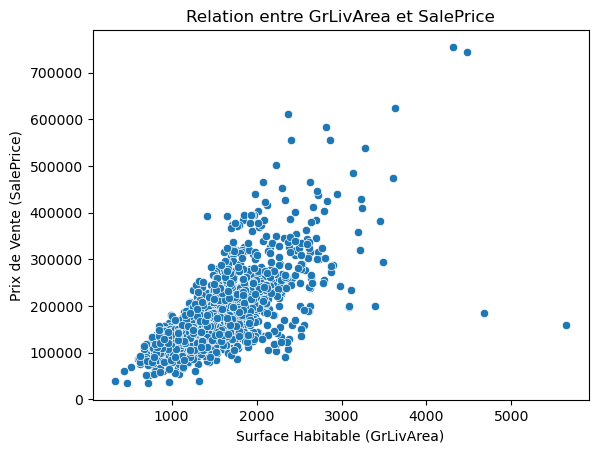

In [222]:
sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'])
plt.title("Relation entre GrLivArea et SalePrice")
plt.xlabel("Surface Habitable (GrLivArea)")
plt.ylabel("Prix de Vente (SalePrice)")
plt.show()


## Graphique 4 : Boxplot OverallQual vs SalePrice

Objectif : 
- Évaluer l’impact de la qualité générale d’une maison sur son prix.

### Tendance croissante : 
- On observe une relation positive claire entre OverallQual et SalePrice. Plus la qualité globale (OverallQual) augmente, plus le prix de vente (SalePrice) tend à être élevé.
- Cela montre que la qualité globale de la maison est un facteur déterminant du prix de vente.

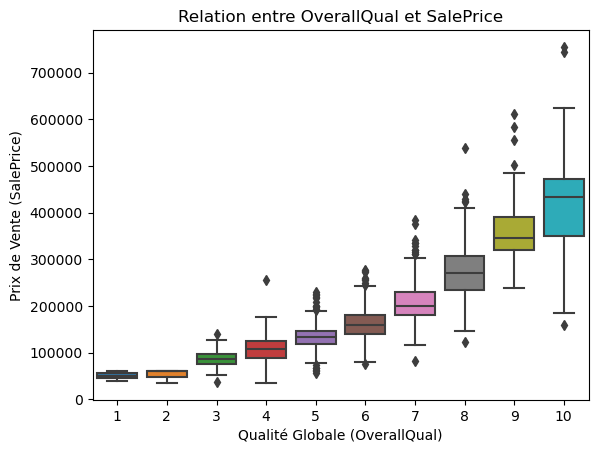

In [223]:
sns.boxplot(x=train_data['OverallQual'], y=train_data['SalePrice'])
plt.title("Relation entre OverallQual et SalePrice")
plt.xlabel("Qualité Globale (OverallQual)")
plt.ylabel("Prix de Vente (SalePrice)")
plt.show()


## Graphique 5: Histogramme des variables numériques

Objectif : 
- Repérer la distribution des principales variables numériques.

In [224]:
# Ce code visualise la distribution des variables numériques du dataset `train_data`.
# 1. Les colonnes numériques sont sélectionnées avec `select_dtypes`.
# 2. Des histogrammes sont tracés pour chaque colonne afin d'analyser leur répartition.
#    - `figsize` ajuste la taille globale.
#    - `bins=20` divise les données en 20 intervalles.
# 3. Un titre global est ajouté pour contextualiser les graphiques.
# Objectif : repérer les asymétries, valeurs aberrantes, et comportements globaux 
# des variables pour guider les transformations ou prétraitements nécessaires.

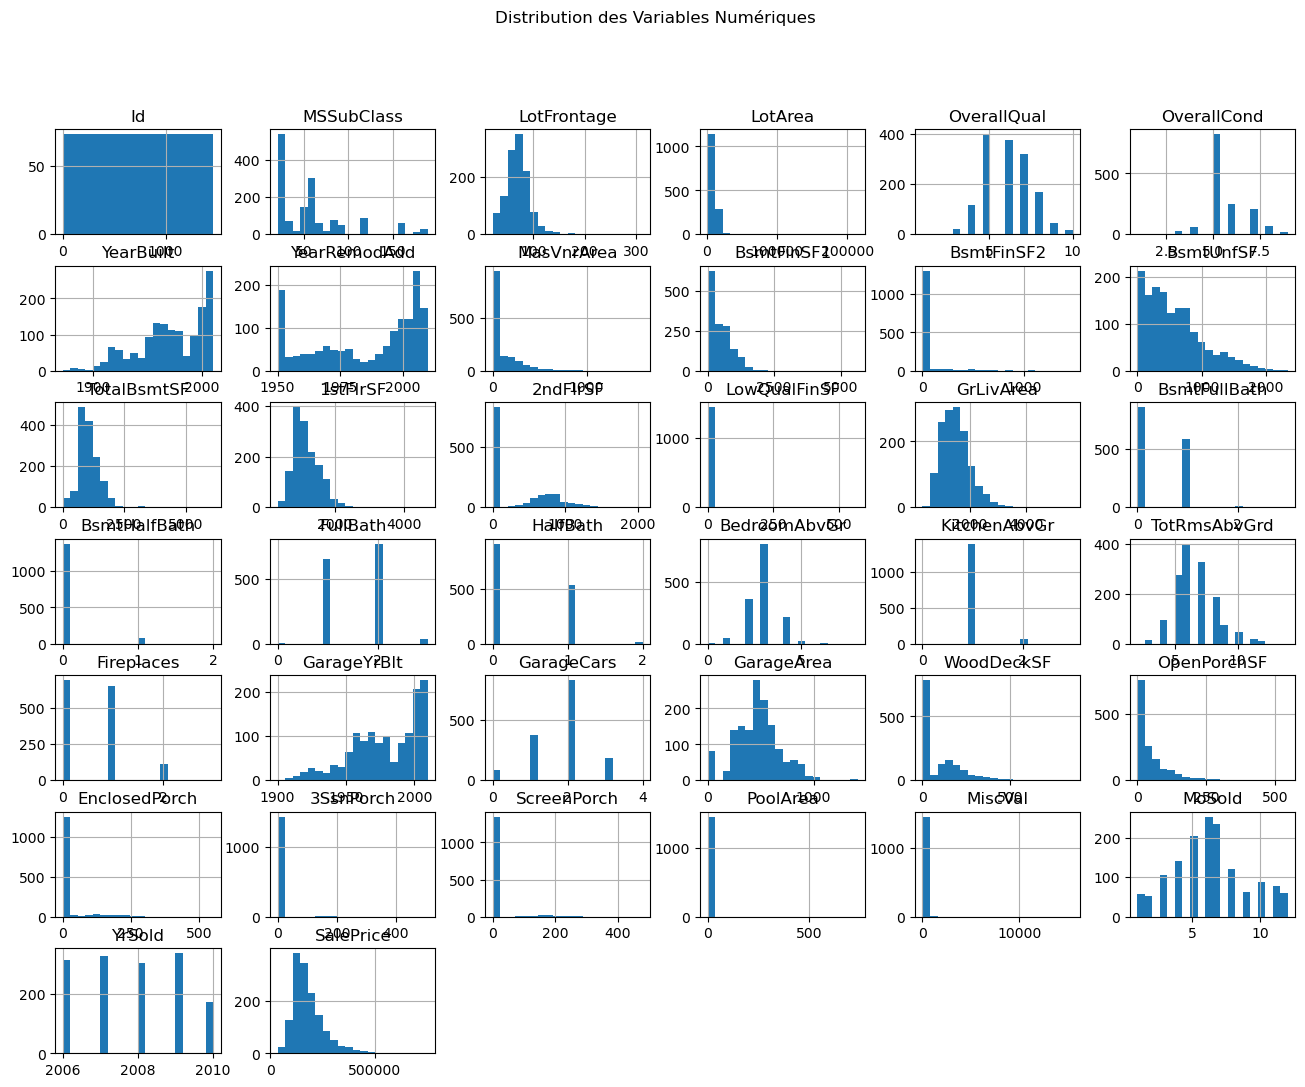

In [225]:
# Distribution des principales variables numériques
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

train_data[numerical_cols].hist(figsize=(16, 12), bins=20)
plt.suptitle("Distribution des Variables Numériques")
plt.show()

## Graphique 6: Comptage des catégories

Objectif : 
- Voir la répartition des valeurs pour certaines colonnes catégoriques clés

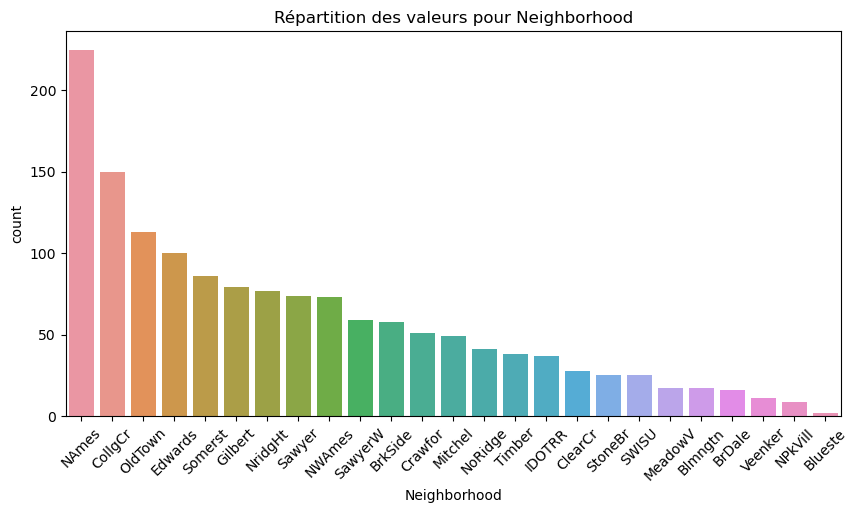

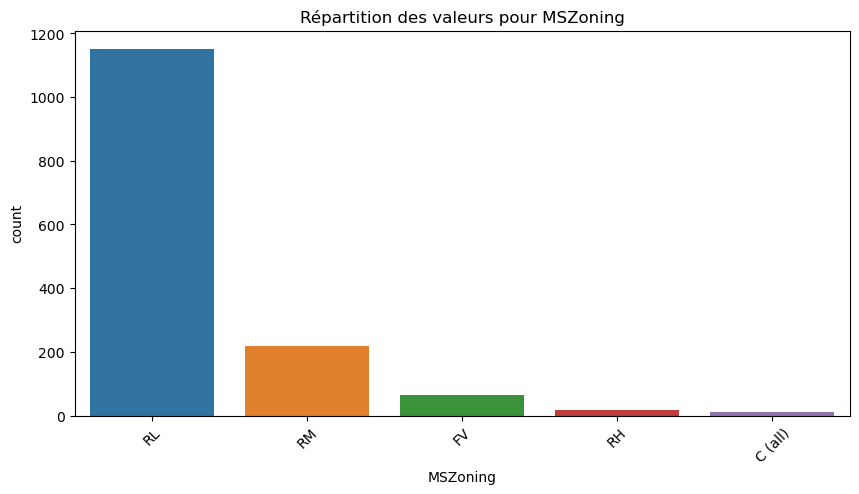

In [226]:
# Distribution des valeurs pour les colonnes catégoriques
cat_features = ['Neighborhood', 'MSZoning']
for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train_data, x=col, order=train_data[col].value_counts().index)
    plt.title(f"Répartition des valeurs pour {col}")
    plt.xticks(rotation=45)
    plt.show()


In [227]:
# Ce code visualise la distribution des valeurs pour les colonnes catégoriques spécifiées.
# 1. Les colonnes catégoriques à analyser sont listées dans `cat_features` (ex. : Neighborhood, MSZoning).
# 2. Pour chaque colonne :
#    - Un graphique de type `countplot` est créé pour afficher le nombre d'occurrences de chaque catégorie.
#    - Les catégories sont triées par fréquence décroissante grâce à `value_counts().index`.
#    - `plt.xticks(rotation=45)` fait pivoter les étiquettes des catégories pour améliorer la lisibilité.
# 3. Un titre est ajouté pour chaque graphique pour indiquer la colonne analysée.
# Objectif : explorer la répartition des catégories et repérer des déséquilibres ou patterns dans les données.


## 4. Préparation des données
Objectif : 
- Ajouter des colonnes dérivées comme LogSalePrice, TotalBathrooms, et TotalPorchSF. Gérer les types de données pour éviter les erreurs.

In [228]:
# Log transformation pour SalePrice
train_data['LogSalePrice'] = np.log1p(train_data['SalePrice'])

# Création de colonnes additionnelles
for df in [train_data, test_data]:
    df['TotalBathrooms'] = df['FullBath'] + 0.5 * df['HalfBath']
    df['TotalPorchSF'] = (
        df['OpenPorchSF'] +
        df['EnclosedPorch'] +
        df['3SsnPorch'] +
        df['ScreenPorch']
    )

# Forcer les colonnes catégoriques à être correctement typées
cat_features = train_data.select_dtypes(include=['object']).columns
train_data[cat_features] = train_data[cat_features].astype('object')
test_data[cat_features] = test_data[cat_features].astype('object')


In [229]:
# Ce code prépare les données en appliquant des transformations logiques et mathématiques.

# 1. Transformation logarithmique de SalePrice :
#    - La colonne `SalePrice` est transformée avec `np.log1p` pour réduire son asymétrie
#      (utile pour améliorer la performance des modèles de régression).

# 2. Création de nouvelles colonnes :
#    - `TotalBathrooms` combine les salles de bain complètes (`FullBath`) et les salles
#      de bain partielles (`HalfBath`), pondérées par 0.5.
#    - `TotalPorchSF` additionne toutes les surfaces liées aux porches (`OpenPorchSF`,
#      `EnclosedPorch`, etc.) pour capturer une caractéristique globale de l'espace extérieur.

# 3. Typage explicite des colonnes catégoriques :
#    - Les colonnes catégoriques (`object`) sont forcées à conserver leur type dans
#      `train_data` et `test_data` afin d'éviter des erreurs potentielles lors de l'encodage.
# Objectif : préparer les données en corrigeant les asymétries, en créant des caractéristiques
# utiles et en s'assurant que les colonnes catégoriques sont correctement typées.


## 5. Séparation des données
Objectif : 
- Diviser les données en caractéristiques (X) et cible (y), et séparer les données d'entraînement en ensembles d'entraînement et de validation.

In [230]:
# Préparation des données pour la modélisation
# 1. Séparation des caractéristiques (X) et de la cible (y : LogSalePrice).
# 2. Conserver uniquement les colonnes communes entre train_data et test_data.
# 3. Division des données en ensembles d'entraînement (80 %) et de validation (20 %).

In [231]:
X = train_data.drop(['SalePrice', 'LogSalePrice'], axis=1)
y = train_data['LogSalePrice']

# Vérification des colonnes communes entre train_data et test_data
common_columns = X.columns.intersection(test_data.columns)
X = X[common_columns]
test_data_prepared = test_data[common_columns]

# Division en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


## 6. Entraînement du modèle
Objectif : 
- Construire un pipeline pour gérer les valeurs manquantes, standardiser les données, encoder les catégories, et entraîner un modèle de régression linéaire.

In [238]:
# Pipeline de préparation des données et modélisation

# 1. Séparation des colonnes numériques et catégoriques.
# 2. Prétraitement :
#    - Numérique : Imputation (médiane) et standardisation.
#    - Catégorique : Imputation (valeur "missing") et encodage OneHot.
# 3. Pipeline complet : Prétraitement suivi d'un modèle de régression linéaire.
# 4. Entraînement : Le pipeline applique le prétraitement sur X_train puis entraîne `LinearRegression`.

In [232]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_features),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrS...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model', LinearRegression())])

## Recherche d’hyperparamètres
Objectif : 
- Optimiser les hyperparamètres pour améliorer les performances du modèle.

In [233]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Exemple avec un modèle Ridge (régression linéaire régularisée)
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

# Définir une grille de valeurs pour les hyperparamètres
ridge_params = {
    'model__alpha': [0.1, 1.0, 10.0, 100.0],  # Coefficient de régularisation
}

# Initialisation de GridSearchCV pour rechercher les meilleurs paramètres
ridge_grid = GridSearchCV(
    ridge_pipeline, 
    param_grid=ridge_params, 
    cv=5,  # Validation croisée à 5 plis
    scoring='neg_root_mean_squared_error',  # Évaluer avec RMSE négatif
    verbose=2
)

# Recherche des meilleurs paramètres sur les données d'entraînement
ridge_grid.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour Ridge : ", ridge_grid.best_params_)
print("Meilleur score (RMSE) : ", -ridge_grid.best_score_)

# Évaluation du modèle optimisé sur les données de validation
y_pred_ridge = ridge_grid.best_estimator_.predict(X_valid)
ridge_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_ridge))
print(f"RMSE sur les données de validation (Ridge optimisé) : {ridge_rmse}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=0.1; total time=   0.0s
[CV] END ...................................model__alpha=1.0; total time=   0.0s
[CV] END ...................................model__alpha=1.0; total time=   0.0s
[CV] END ...................................model__alpha=1.0; total time=   0.0s
[CV] END ...................................model__alpha=1.0; total time=   0.0s
[CV] END ...................................model__alpha=1.0; total time=   0.0s
[CV] END ..................................model__alpha=10.0; total time=   0.0s
[CV] END ..................................model_

In [234]:
# Ce code applique une recherche d'hyperparamètres (GridSearchCV) sur un modèle Ridge (régression linéaire régularisée).

# 1. Importation des bibliothèques :
#    - `GridSearchCV` : Permet de rechercher automatiquement les meilleurs hyperparamètres.
#    - `Ridge` : Modèle de régression linéaire régularisée avec une pénalité L2.
#    - `RandomForestRegressor` est également importé mais non utilisé ici.

# 2. Définition d'un pipeline :
#    - `preprocessor` : Composant chargé de prétraiter les données.
#    - `model` : Modèle Ridge intégré au pipeline pour faciliter la recherche des hyperparamètres.

# 3. Grille d'hyperparamètres :
#    - `model__alpha` : Contrôle l'importance de la régularisation. Plusieurs valeurs (0.1, 1.0, etc.) sont testées.

# 4. Configuration de GridSearchCV :
#    - `param_grid` : Définit les hyperparamètres à tester (ici, les valeurs d'alpha).
#    - `cv=5` : Validation croisée à 5 plis pour garantir une évaluation robuste.
#    - `scoring='neg_root_mean_squared_error'` : Critère d'évaluation basé sur RMSE (négatif car par convention avec sklearn).
#    - `verbose=2` : Affiche la progression des tests pour suivre l'exécution.

# 5. Entraînement avec recherche des meilleurs paramètres :
#    - La méthode `.fit()` entraîne le modèle en testant toutes les combinaisons d'hyperparamètres sur les données d'entraînement.

# 6. Résultats :
#    - `ridge_grid.best_params_` : Renvoie les meilleurs hyperparamètres trouvés (valeur optimale d'alpha).
#    - `ridge_grid.best_score_` : Score moyen du meilleur modèle sur les données de validation croisée (en RMSE négatif).

# 7. Évaluation finale :
#    - Le modèle optimisé est évalué sur l'ensemble de validation (`X_valid`).
#    - Le RMSE sur ces données est calculé avec `mean_squared_error` pour mesurer la performance.

# Objectif : Optimiser le modèle Ridge en ajustant les hyperparamètres pour obtenir les meilleures performances (faible RMSE).


## 7. Analyse des résidus
## Graphique 5 : Distribution des résidus

- Objectif : Vérifier si les résidus suivent une distribution normale, ce qui indique un bon ajustement du modèle.

/Users/noakassabi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


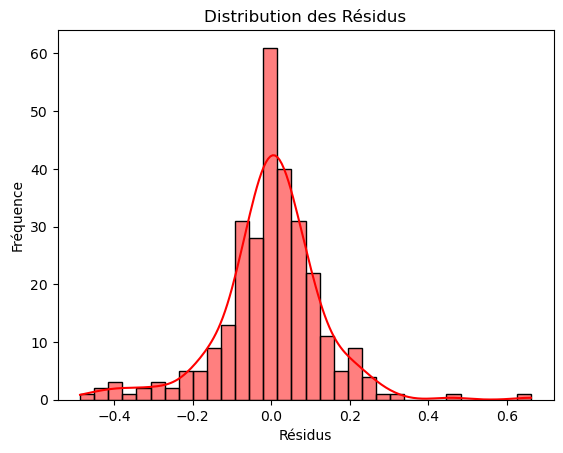

In [235]:
residuals = y_valid - pipeline.predict(X_valid)
sns.histplot(residuals, kde=True, color='red')
plt.title("Distribution des Résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()


## Graphique 6 : Scatterplot des résidus vs prédictions

Objectif : 
- Vérifier que les résidus sont uniformément répartis autour de 0, sans motifs.

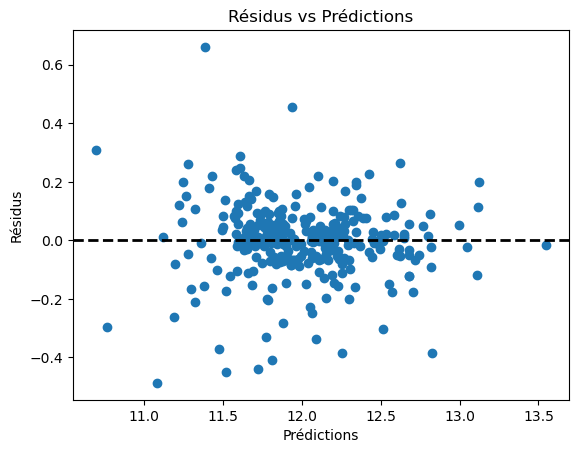

In [236]:
plt.scatter(pipeline.predict(X_valid), residuals)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.title("Résidus vs Prédictions")
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.show()


## 8. Prédictions finales et soumission
Objectif : 
- Appliquer le modèle aux données de test, faire des prédictions, et générer un fichier CSV pour la soumission.

In [237]:
test_predictions = pipeline.predict(test_data_prepared)
test_data['SalePrice'] = np.expm1(test_predictions)
submission = test_data[['Id', 'SalePrice']]
submission.to_csv('submission.csv', index=False)
print("Fichier de soumission créé : submission.csv")


Fichier de soumission créé : submission.csv
